## Analyzing Research Articles using Topic Modelling Approach


In [1]:
#Importing neccessary libraries

import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [2]:
# Load and read datasets

papers = pd.read_excel('C:/Users/Saleeh/Documents/Salford University/Lectures/AI - Natural Language Processing/Assessment/Dataset/Scopus Extract/Scopus dataset.xlsx')

In [3]:
# View first 5 rows of data 

papers.head()

,Authors,Title,Year,Source title,Link,Abstract,Author Keywords
0,Belguith S.; Kaaniche N.; Laurent M.; Jemai A....,Accountable privacy preserving attribute based...,2020,Journal of Parallel and Distributed Computing,https://www.scopus.com/inward/record.uri?eid=2...,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...
1,Kumaran G.; Sivaraj R.; Ramachandra Prasad V.;...,Finite difference computation of free magneto-...,2021,Physica Scripta,https://www.scopus.com/inward/record.uri?eid=2...,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...
2,Zahedi E.; Saraee M.; Masoumi F.S.; Yazdinejad M.,Regularized Contrastive Masked Autoencoder Mod...,2023,Algorithms,https://www.scopus.com/inward/record.uri?eid=2...,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...
3,Oladipupo M.A.; Obuzor P.C.; Bamgbade B.J.; Ol...,An Automated Python Script for Data Cleaning a...,2023,Informatica (Slovenia),https://www.scopus.com/inward/record.uri?eid=2...,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...
4,Roy A.K.; Debnath S.; Bég O.A.,Transient solute dispersion in electro-osmotic...,2023,ZAMM Zeitschrift fur Angewandte Mathematik und...,https://www.scopus.com/inward/record.uri?eid=2...,The transport of a neutral solute in incompres...,NaN


In [4]:
papers.describe(include = 'all')

,Authors,Title,Year,Source title,Link,Abstract,Author Keywords
count,1142,1142,1142.000000,1142,1142,1142,1026
unique,998,1040,NaN,613,1040,1026,931
top,Lomas D.W.B.,Dynamic modeling and characterization of compl...,NaN,Journal of Strength and Conditioning Research,https://www.scopus.com/inward/record.uri?eid=2...,[No abstract available],cable vibration; cable-driven parallel robot; ...
freq,4,3,NaN,27,3,15,3
mean,NaN,NaN,2022.069177,NaN,NaN,NaN,NaN
std,NaN,NaN,1.366795,NaN,NaN,NaN,NaN
min,NaN,NaN,2019.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,2022.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,2022.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,2023.000000,NaN,NaN,NaN,NaN


Datasets has different number of unique values for title and abstract and total number of records indicating that some documents may have similar titles or abstracts across different subject classes.

In [5]:
# summary of the columns in the dataset
# Totals rows of that is 303

papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Authors          1142 non-null   object
 1   Title            1142 non-null   object
 2   Year             1142 non-null   int64 
 3   Source title     1142 non-null   object
 4   Link             1142 non-null   object
 5   Abstract         1142 non-null   object
 6   Author Keywords  1026 non-null   object
dtypes: int64(1), object(6)
memory usage: 62.6+ KB


In [6]:
# Remove columns that does not relate to the task
# Add paper_text column

papers = papers.drop(columns=['Authors','Source title','Link'], axis=1)

#print out the first five rows of papers
papers.head()

,Title,Year,Abstract,Author Keywords
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...
4,Transient solute dispersion in electro-osmotic...,2023,The transport of a neutral solute in incompres...,NaN


In [7]:
# Add paper_text column
papers['paper_text'] = papers['Title'] + " " + papers['Abstract']

#print out the first five rows of papers
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Accountable privacy preserving attribute based...
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Finite difference computation of free magneto-...
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Regularized Contrastive Masked Autoencoder Mod...
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,An Automated Python Script for Data Cleaning a...
4,Transient solute dispersion in electro-osmotic...,2023,The transport of a neutral solute in incompres...,NaN,Transient solute dispersion in electro-osmotic...


In [8]:
# Remove missing values

papers = papers.dropna(axis='rows')

papers.head()

,Title,Year,Abstract,Author Keywords,paper_text
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Accountable privacy preserving attribute based...
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Finite difference computation of free magneto-...
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Regularized Contrastive Masked Autoencoder Mod...
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,An Automated Python Script for Data Cleaning a...
5,Evaluating the Risk of Disclosure and Utility ...,2021,The advancement of information technology has ...,Differential privacy; privacy; risk of disclos...,Evaluating the Risk of Disclosure and Utility ...


# Text Preprocessing

The Text preprocessing step will be carried out in the following step

1. Data Cleaning
2. Tokenization
3. Stopword Removal
4. Normalization
5. Text Encoding
6. Vectorization
7. Data Splitting

In [9]:
#Import neccessary libraries for text preprocessing

import re
from string import punctuation
import contractions

In [10]:
#Create a function for preprocessing

def clean_text(text):
    # make text lowercase    
    text = str(text).lower()
    # expand contractions
    text = " ".join([contractions.fix(expanded_word) for expanded_word in text.split()])
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    # remove new lines
    text = re.sub('\n', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # remove apostrophes
    text = re.sub("''", '', text)
    return text

In [11]:
# apply function on each text in the dataset

papers['paper_text_preprocessed'] = papers['paper_text'].apply(lambda x: clean_text(x))

papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Accountable privacy preserving attribute based...,accountable privacy preserving attribute based...
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Finite difference computation of free magneto-...,finite difference computation of free magnetoc...
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Regularized Contrastive Masked Autoencoder Mod...,regularized contrastive masked autoencoder mod...
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,An Automated Python Script for Data Cleaning a...,an automated python script for data cleaning a...
5,Evaluating the Risk of Disclosure and Utility ...,2021,The advancement of information technology has ...,Differential privacy; privacy; risk of disclos...,Evaluating the Risk of Disclosure and Utility ...,evaluating the risk of disclosure and utility ...


### Tokenization

In [12]:
### Add comment

from nltk.tokenize import word_tokenize
papers['paper_words'] = papers['paper_text_preprocessed'].apply(lambda x:word_tokenize(str(x)))
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed,paper_words
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Accountable privacy preserving attribute based...,accountable privacy preserving attribute based...,"[accountable, privacy, preserving, attribute, ..."
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Finite difference computation of free magneto-...,finite difference computation of free magnetoc...,"[finite, difference, computation, of, free, ma..."
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Regularized Contrastive Masked Autoencoder Mod...,regularized contrastive masked autoencoder mod...,"[regularized, contrastive, masked, autoencoder..."
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,An Automated Python Script for Data Cleaning a...,an automated python script for data cleaning a...,"[an, automated, python, script, for, data, cle..."
5,Evaluating the Risk of Disclosure and Utility ...,2021,The advancement of information technology has ...,Differential privacy; privacy; risk of disclos...,Evaluating the Risk of Disclosure and Utility ...,evaluating the risk of disclosure and utility ...,"[evaluating, the, risk, of, disclosure, and, u..."


### Stop words removal

In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     EE certificate key too weak (_ssl.c:1006)>


False

In [14]:
# define stopword removal function
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', "'",'used','using','one','two','also','use','us','may'])

def remove_stopword(word_list):
    return [word for word in word_list if word not in stop_words]

papers['paper_words_excl_sw'] = papers['paper_words'].apply(lambda x: remove_stopword(x))

In [15]:
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed,paper_words,paper_words_excl_sw
0,Accountable privacy preserving attribute based...,2020,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Accountable privacy preserving attribute based...,accountable privacy preserving attribute based...,"[accountable, privacy, preserving, attribute, ...","[accountable, privacy, preserving, attribute, ..."
1,Finite difference computation of free magneto-...,2021,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Finite difference computation of free magneto-...,finite difference computation of free magnetoc...,"[finite, difference, computation, of, free, ma...","[finite, difference, computation, free, magnet..."
2,Regularized Contrastive Masked Autoencoder Mod...,2023,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Regularized Contrastive Masked Autoencoder Mod...,regularized contrastive masked autoencoder mod...,"[regularized, contrastive, masked, autoencoder...","[regularized, contrastive, masked, autoencoder..."
3,An Automated Python Script for Data Cleaning a...,2023,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,An Automated Python Script for Data Cleaning a...,an automated python script for data cleaning a...,"[an, automated, python, script, for, data, cle...","[automated, python, script, data, cleaning, la..."
5,Evaluating the Risk of Disclosure and Utility ...,2021,The advancement of information technology has ...,Differential privacy; privacy; risk of disclos...,Evaluating the Risk of Disclosure and Utility ...,evaluating the risk of disclosure and utility ...,"[evaluating, the, risk, of, disclosure, and, u...","[evaluating, risk, disclosure, utility, synthe..."


### Lemmatization

After removing stopwords, I applied lemmatization technique to further preprocces the text data bu converting each word to its base form

In [16]:
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
papers['paper_words_excl_sw'] = papers['paper_words_excl_sw'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
papers.tail()

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     EE certificate key too weak (_ssl.c:1006)>


,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed,paper_words,paper_words_excl_sw
1137,The role of the TUC in significant industrial ...,2019,Historically the British Trades Union Congress...,1926 general strike; 1984/5 miners’ strike; Br...,The role of the TUC in significant industrial ...,the role of the tuc in significant industrial ...,"[the, role, of, the, tuc, in, significant, ind...","[role, tuc, significant, industrial, dispute, ..."
1138,Relevance theory and metaphor: An analysis of ...,2019,‘Emotional Weather Report’ is a song by Tom Wa...,Carston; extended metaphor; metaphor; relevanc...,Relevance theory and metaphor: An analysis of ...,relevance theory and metaphor an analysis of t...,"[relevance, theory, and, metaphor, an, analysi...","[relevance, theory, metaphor, analysis, tom, w..."
1139,Improving Arabic neural machine translation vi...,2019,Even though the rise of the neural machine tra...,Machine translation; Natural language processi...,Improving Arabic neural machine translation vi...,improving arabic neural machine translation vi...,"[improving, arabic, neural, machine, translati...","[improving, arabic, neural, machine, translati..."
1140,Dark night of the soul: Applicability of theor...,2019,This article responds to McCloud’s theoretical...,Audio drama; Comics studies; Marvel; Podcasts;...,Dark night of the soul: Applicability of theor...,dark night of the soul applicability of theory...,"[dark, night, of, the, soul, applicability, of...","[dark, night, soul, applicability, theory, com..."
1141,Effects of “Visual Schema Displacement Therapy...,2019,Background and objectives: Visual Schema Displ...,EMDR; PTSD; Trauma therapy; Visual Schema Disp...,Effects of “Visual Schema Displacement Therapy...,effects of “visual schema displacement therapy...,"[effects, of, “, visual, schema, displacement,...","[effect, “, visual, schema, displacement, ther..."


## Visualize the data using wordcloud package

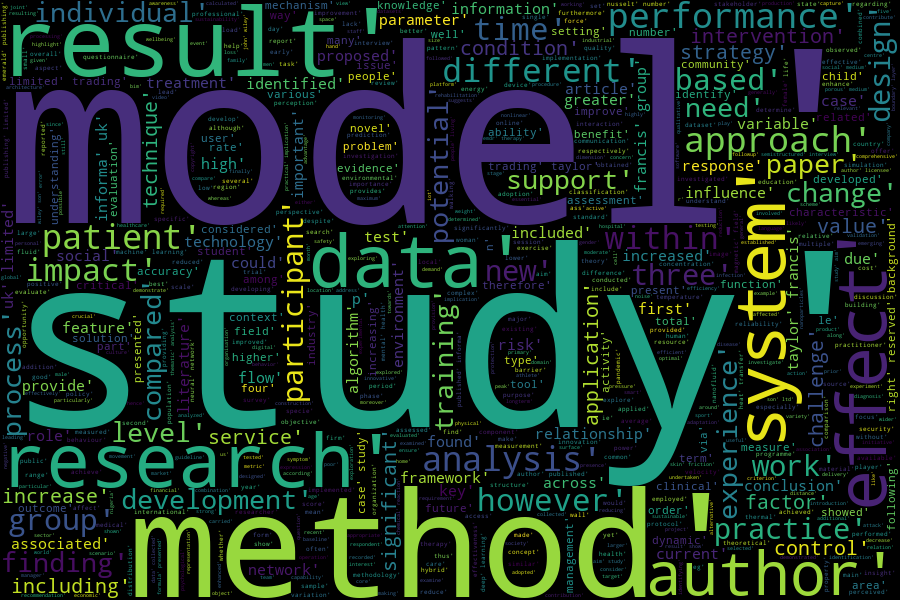

In [17]:
# Visualize the data using wordcloud package
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together
long_string = ','.join((str(l) for l in papers['paper_words_excl_sw']))
                       
# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=3000, contour_width=3, contour_color='steelblue', width = 900, height = 600)

#Generate a word cloud
wordcloud.generate(long_string)

#Visualize the word cloud
wordcloud.to_image()

## LDA Analysis

In [18]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

        
data = papers['paper_words_excl_sw'].tolist()
data_words = list(sent_to_words(data))


print(data_words[:2][0][:10])

['accountable', 'privacy', 'preserving', 'attribute', 'based', 'framework', 'authenticated', 'encrypted', 'access', 'cloud']


In [19]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:10])

[(0, 3), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1)]


## LDA model training

In [29]:
from pprint import pprint

# number of topics
num_topics = 8

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"study" + 0.004*"model" + 0.004*"result" + 0.004*"patient" + '
  '0.003*"analysis" + 0.003*"author" + 0.003*"system" + 0.003*"research" + '
  '0.003*"approach" + 0.003*"group"'),
 (1,
  '0.006*"study" + 0.006*"model" + 0.004*"data" + 0.004*"performance" + '
  '0.004*"method" + 0.004*"result" + 0.004*"group" + 0.003*"approach" + '
  '0.003*"paper" + 0.003*"number"'),
 (2,
  '0.008*"study" + 0.007*"data" + 0.005*"research" + 0.005*"method" + '
  '0.004*"analysis" + 0.004*"model" + 0.004*"result" + 0.003*"group" + '
  '0.003*"approach" + 0.003*"author"'),
 (3,
  '0.009*"study" + 0.007*"model" + 0.005*"data" + 0.004*"research" + '
  '0.004*"analysis" + 0.004*"system" + 0.004*"author" + 0.003*"paper" + '
  '0.003*"result" + 0.003*"health"'),
 (4,
  '0.008*"model" + 0.005*"study" + 0.005*"network" + 0.004*"result" + '
  '0.004*"system" + 0.004*"research" + 0.003*"proposed" + 0.003*"author" + '
  '0.003*"data" + 0.003*"performance"'),
 (5,
  '0.010*"study" + 0.005*"model" + 0.00

## Analyzing LDA model

Now, let's visualize the topics to identify patterns for interpretability using pyLDAvis

In [30]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('content_'+str(num_topics) + '.pickle')

if not os.path.exists(LDAvis_data_filepath):
    # Prepare the LDA visualization data
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    # Save the prepared data to disk
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # Load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the HTML visualization
pyLDAvis.save_html(LDAvis_prepared, 'content_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.019241  0.009090       1        1  16.949432
5     -0.008863  0.005216       2        1  16.783240
3     -0.009157  0.008621       3        1  16.606224
2     -0.018591  0.007543       4        1  15.021070
7     -0.007318 -0.003813       5        1  13.916937
1      0.015073 -0.003646       6        1   7.770177
0      0.006922 -0.041305       7        1   7.118273
4      0.041176  0.018294       8        1   5.834647, topic_info=             Term        Freq       Total Category  logprob  loglift
166         model  753.000000  753.000000  Default  30.0000  30.0000
940       network  246.000000  246.000000  Default  29.0000  29.0000
415   performance  376.000000  376.000000  Default  28.0000  28.0000
452     algorithm  172.000000  172.000000  Default  27.0000  27.0000
57       proposed  280.000000  280.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
335          time   17.945887  351.293614   Topic8  -6.2059  -0.1329
48          paper   17.838296  355.030912   Topic8  -6.2119  -0.1495
1479       factor   15.724291  270.573291   Topic8  -6.3381  -0.0040
11          based   15.191606  241.800939   Topic8  -6.3726   0.0740
217         value   15.206590  256.528021   Topic8  -6.3716   0.0158

[680 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
8437       1  0.735104  absenteeism
12367      1  0.785469     acquirer
12367      7  0.261823     acquirer
4562       1  0.099967    activated
4562       2  0.099967    activated
...      ...       ...          ...
2760       4  0.108433         year
2760       5  0.131261         year
2760       6  0.079898         year
2760       7  0.034242         year
2760       8  0.039949         year

[2068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 3, 8, 2, 1, 5])